In [2]:
%matplotlib inline

import sys
import os
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib
from matplotlib import pyplot as plt, animation, rc,colors
from datetime import datetime, timedelta
from cartopy import crs, feature
import cmocean
import yaml

from IPython.display import Image
rc('animation', html='html5')

sys.path.append('/home/jvalenti/MOAD/analysis-jose/Source')
from OP_functions import *
sys.path.append('/home/jvalenti/MOAD/SalishSeaTools')
from salishsea_tools import evaltools as et

fatal: not a git repository (or any parent up to mount point /)
Stopping at filesystem boundary (GIT_DISCOVERY_ACROSS_FILESYSTEM not set).
/home/jvalenti/MOAD/SalishSeaTools/salishsea_tools/evaltools.py:49: UserWarning: Neither Python Excel module ('openpyxl','xlrd') found
  warnings.warn("Neither Python Excel module ('openpyxl','xlrd') found",UserWarning)


In [3]:
# Define paths
local = 0 #Set to 0 when working on server
paths = path(local)
coords = xr.open_dataset(paths['coords'], decode_times=False)
mask = xr.open_dataset(paths['mask'])

In [4]:
df=pd.read_csv('/home/jvalenti/MOAD/analysis-jose/OParcels/timeg_2016.csv', index_col=[0])

meantime = df.groupby(by='DeployT').mean()
SD = df.groupby(by='DeployT').sem()
meantime.Timeg = meantime.Timeg/24
SD.Timeg = (SD.Timeg/24)

In [5]:
def getWindVars(day):
    opsdir='/results/forcing/atmospheric/GEM2.5/operational/'
    nam_fmt='ops'
    jlims=(119,213)
    ilims=(96,163)
    return opsdir, nam_fmt, jlims,ilims

In [6]:
start = datetime(2016,1,1)
opsdir, namfmt, jlims,ilims = getWindVars(start)
DeltaT = timedelta(days= 7)
flist=et.index_model_files(start,start+DeltaT,opsdir,namfmt,
                            flen=1,ftype='None',tres=24);

In [33]:
start = datetime(2016,1,1)

def Qubicwind_tmean(start, DeltaT):
    opsdir, namfmt, jlims, ilims = getWindVars(start)
    flist=et.index_model_files(start,start+DeltaT,opsdir,namfmt,
                            flen=1,ftype='None',tres=24);
    fs=[xr.open_dataset(ii,chunks='auto') for ii in flist['paths']]
    fu=xr.concat([ii['u_wind'].isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
    fv=xr.concat([ii['v_wind'].isel(x=slice(ilims[0],ilims[1]),y=slice(jlims[0],jlims[1])) for ii in fs],"time_counter")
    Week1=(fu**2+fv**2)**(3/2)
    umean = np.nanmean(np.mean(fu,0))
    vmean = np.nanmean(np.mean(fv,0))
    Windir = np.arctan(np.divide(vmean,umean))
    Week1mean=np.mean(Week1,0)
    return np.nanmean(Windir), np.nanmean(Week1mean)
Qwind = [] 
Windir = [] 
for i in range(1,49):
    Wdr,Qww = Qubicwind_tmean(start, timedelta(days= 7))
    Qwind.append(Qww)
    Windir.append(Wdr)
    start = start+timedelta(days= 7)

In [10]:
start = datetime(2015,12,25)
Fraser_week = [] 
for i in range(48):
    Fraser_week.append(0)
    for j in range(168):
        Fraser_week[-1] += float(xr.open_dataset(get_Fraser_path(start+ timedelta(days= i*7,hours=j))).rorunoff[0,500,394].values)*211.8116*3600 #m3/h

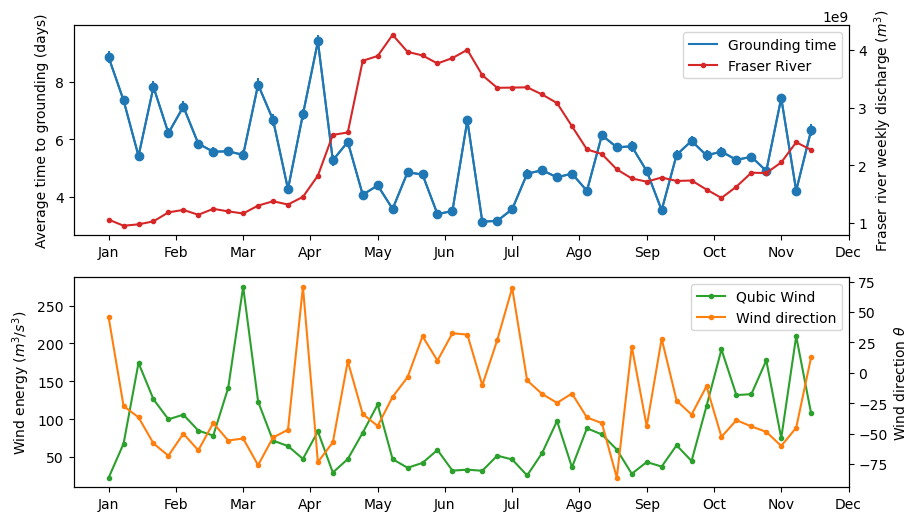

In [34]:
Dept = meantime.index
Groundt = meantime.values
SE = SD.values

se = []
gt = []
for i in range(48):
    se.append(SE[i][0])
    gt.append(Groundt[i][0])

fig,ax = plt.subplots(2,1,figsize=(10,6))
Twin1 = ax[0].twinx()
Twin2 = ax[1].twinx()

ax[0].errorbar(Dept,gt,yerr=se,fmt='-o')

p1 = ax[0].plot(Dept,gt,c='tab:blue',label = 'Grounding time')
plt.xlabel('Time of particle deployment')
ax[0].set_ylabel('Average time to grounding (days)')
Twin1.set_ylabel('Fraser river weekly discharge ($m^3$)')
p2 = Twin1.plot(Dept,Fraser_week,'.-',c='tab:red',label = 'Fraser River')
p3 = ax[1].plot(Dept,Qwind,'.-',c='tab:green',label = 'Qubic Wind')
p4 = Twin2.plot(Dept,np.array(Windir)*180/np.pi,'.-',c='tab:orange',label = 'Wind direction')
ax[1].set_ylabel('Wind energy ($m^3/s^3$)')
Twin2.set_ylabel(r'Wind direction $\theta$')

AX1 = p1+p2
labs = [l.get_label() for l in AX1]
ax[0].legend(AX1,labs)


AX2 = p3+p4
labs = [l.get_label() for l in AX2]
ax[1].legend(AX2,labs,loc = 'upper right')
a=ax[0].set_xticks(np.arange(0,50,4.5), ['Jan', 'Feb', 'Mar','Apr','May','Jun','Jul','Ago','Sep','Oct','Nov','Dec'])
a=ax[1].set_xticks(np.arange(0,50,4.5), ['Jan', 'Feb', 'Mar','Apr','May','Jun','Jul','Ago','Sep','Oct','Nov','Dec'])
